In [5]:
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession

import matplotlib.pyplot as plt
import matplotlib as mpl
import colorcet as cc

In [6]:
# just making jupyter wider
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

### Useful Constants, Setup, etc.

In [7]:
# list of US states
state_names = ["Alabama","Alaska","Arizona","Arkansas","California","Colorado","Connecticut","Delaware","Florida","Georgia","Hawaii","Idaho","Illinois",
               "Indiana","Iowa","Kansas","Kentucky","Louisiana","Maine","Maryland","Massachusetts","Michigan","Minnesota","Mississippi","Missouri","Montana",
               "Nebraska","Nevada","New Hampshire","New Jersey","New Mexico","New York","North Carolina","North Dakota","Ohio","Oklahoma","Oregon","Pennsylvania",
               "Rhode Island","South Carolina","South Dakota","Tennessee","Texas","Utah","Vermont","Virginia","Washington","West Virginia","Wisconsin","Wyoming"]

# function for pulling out states
isState = np.vectorize(lambda x: x in state_names)

# set plotsize and style
plt.rcParams['figure.figsize'] = 16, 5
mpl.style.use('ggplot')

### Load Data

In [27]:
css_confirmed = pd.read_csv('csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')
css_confirmed.rename({'Province/State': 'state', 'Country/Region': 'country'}, inplace=True, axis=1)

css_deaths = pd.read_csv('csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv')
css_deaths.rename({'Province/State': 'state', 'Country/Region': 'country'}, inplace=True, axis=1)

css_recovered = pd.read_csv('csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv')
css_recovered.rename({'Province/State': 'state', 'Country/Region': 'country'}, inplace=True, axis=1)

# most recent day
today = css_confirmed.columns[-1]

In [10]:
css_confirmed[css_confirmed.country == 'US'].sort_values(by=today, ascending=False)

,state,country,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20
99,New York,US,42.1657,-74.9481,0,0,0,0,0,0,...,328,421,525,732,967,1706,2495,5365,8310,11710
98,Washington,US,47.4009,-121.4905,0,0,0,0,0,0,...,442,568,572,643,904,1076,1014,1376,1524,1793
100,California,US,36.1162,-119.6816,0,0,0,0,0,0,...,221,282,340,426,557,698,751,952,1177,1364
107,New Jersey,US,40.2989,-74.5210,0,0,0,0,0,0,...,29,29,69,98,178,267,267,742,890,1327
146,Michigan,US,43.3266,-84.5361,0,0,0,0,0,0,...,2,16,25,33,53,65,83,334,552,788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,"Washington, D.C.",US,38.9072,-77.0369,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
212,"Napa, CA",US,38.5025,-122.2654,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
281,"Alameda County, CA",US,37.6017,-121.7195,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
282,"Broward County, FL",US,26.1901,-80.3659,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Create Useful DataFrames
## Basic Data Aggregation
### Data Aggregated by Country

In [11]:
by_country = css_confirmed[pd.isna(css_confirmed.state)].drop(['state', 'Lat', 'Long'], axis=1)\
                                                        .set_index('country')\
                                                        .sort_values(by=today, ascending=False)

### Data Aggregated by US State

In [67]:
by_state = css_confirmed[isState(css_confirmed.state)].drop(['country', 'Lat', 'Long'], axis=1)\
                                                      .set_index('state')\
                                                      .sort_values(by=today, ascending=False)

deaths_by_state = css_deaths[isState(css_deaths.state)].drop(['country', 'Lat', 'Long'], axis=1)\
                                                       .set_index('state')
                                                       

recovered_by_state = css_recovered[isState(css_recovered.state)].drop(['country', 'Lat', 'Long'], axis=1)\
                                                                .set_index('state')

deaths_by_state = deaths_by_state.loc[by_state.index].copy()
recovered_by_state = recovered_by_state.loc[by_state.index].copy()

## 
### Number of New Confirmed Cases Daily

In [13]:
# create dataframe that tracks new cases on a daily basis
temp = (css_confirmed.values[:, 4:] - np.roll(css_confirmed.values[:, 4:], 1, axis=1))[:, 1:]
new_daily_cases = css_confirmed.drop('1/22/20', axis=1)
new_daily_cases.iloc[:, 4:] = temp
new_daily_cases = new_daily_cases.sort_values(by=today, ascending=False)

### DataFrame for New Cases in US Daily

In [14]:
new_daily_cases_US = new_daily_cases[new_daily_cases.country == 'US'].drop(['country', 'Lat', 'Long'], axis=1)
new_daily_cases_US = new_daily_cases_US[isState(new_daily_cases_US)].groupby('state')\
                                                                    .sum()\
                                                                    .sort_values(by=today, ascending=False)

# Data Visualization
## United States

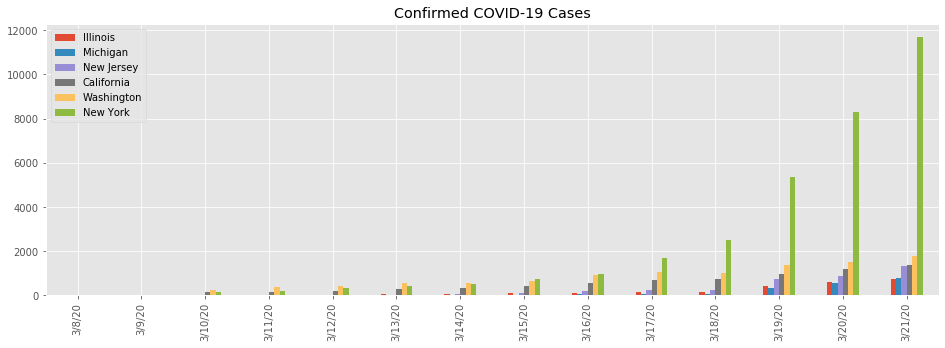

In [15]:
ax = by_state.iloc[:6, 46:][::-1].T.plot(kind='bar')

ax.set_title('Confirmed COVID-19 Cases')
ax.legend(loc='upper left')
plt.show()

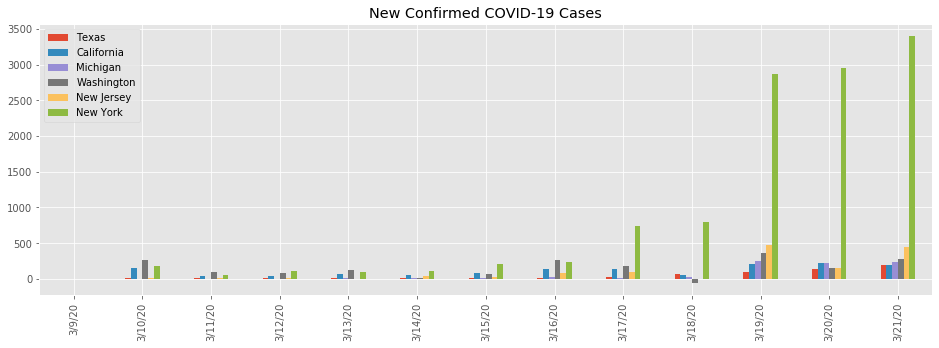

In [16]:
ax = new_daily_cases_US.iloc[:6, 46:][::-1].T.plot(kind='bar')

ax.set_title('New Confirmed COVID-19 Cases')
ax.legend(loc='upper left')

plt.show()

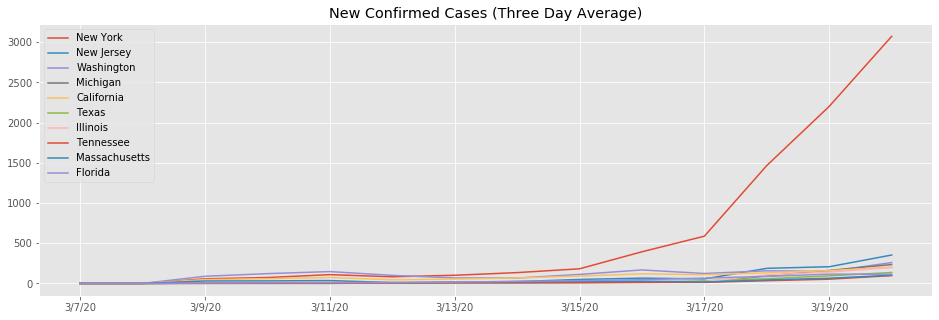

In [17]:
ax = new_daily_cases_US.rolling(3, center=True, axis=1).mean().iloc[:10, 44:].T.plot()

ax.legend(loc='upper left')
ax.set_title('New Confirmed Cases (Three Day Average)')

plt.show()

## Worldwide

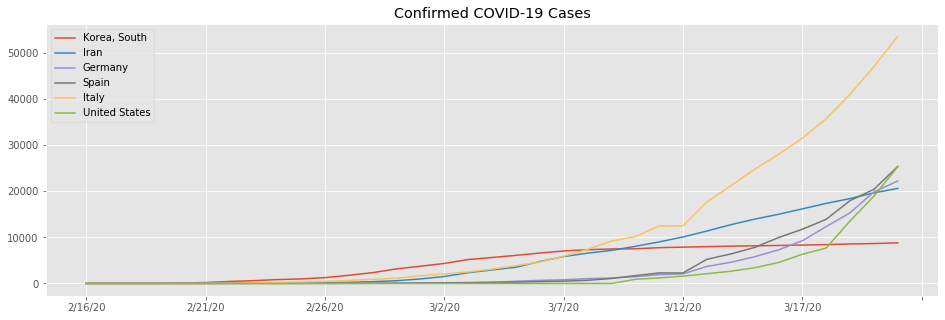

In [18]:
ax = by_country.iloc[:5, 25:][::-1].T.plot()


plt.plot(by_state.sum()[25:], label='United States')

ax.set_title('Confirmed COVID-19 Cases')
ax.legend(loc='upper left')
plt.savefig('covid-by-country.png', dpi=300)
plt.show()

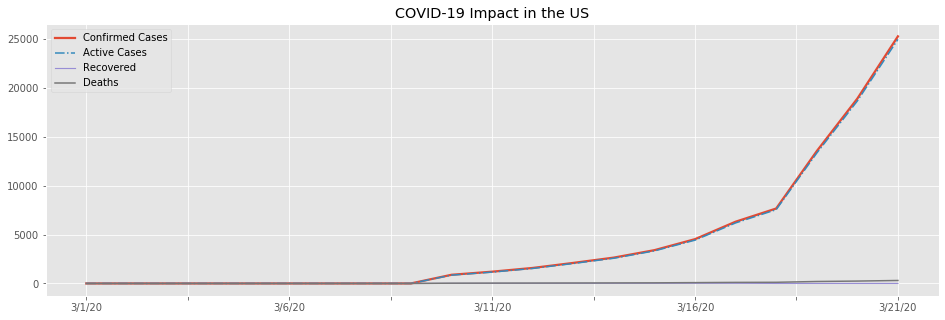

In [99]:
start = 39

ax = by_state.sum()[start:].plot(label='Confirmed Cases', lw=2.25)
ax.plot((by_state - deaths_by_state - recovered_by_state).sum()[start:], label='Active Cases', ls='-.', lw=1.5)
ax.plot(recovered_by_state.sum()[start:], label='Recovered', lw=1.15)
ax.plot(deaths_by_state.sum()[start:], label='Deaths', lw=1.5)



ax.set_title('COVID-19 Impact in the US')
ax.legend(loc='upper left')
plt.show()